### 옵션 2: Google Drive 마운트하여 이미지 접근하기

이미지가 Google Drive에 있다면, 다음 코드를 실행하여 Google Drive를 Colab에 마운트할 수 있습니다. 마운트 후에는 `img_path`를 Google Drive 내의 파일 경로로 수정해야 합니다.

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os

# ==============================================================================
# ▼▼▼ [필수 수정] 여기 경로를 실제 이미지 파일 경로로 바꿔주세요! ▼▼▼
# 예시: 'Z:/home/AI_Project/occupancy_networks/data/ShapeNet/02958343/1a0bc9ab92c915167ae33d942430658c/view_00.jpg'
image_path = '/content/016.jpg'
# ==============================================================================

def plot_dwt_18_features(img_path):
    if not os.path.exists(img_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다! 경로를 확인해주세요:\n{img_path}")
        return

    # 1. 이미지 로드 및 RGB로 변환
    img = cv2.imread(img_path)
    if img is None:
         print("❌ 오류: 이미지를 읽을 수 없습니다. 파일이 손상되었거나 경로가 잘못되었습니다.")
         return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 결과물을 담을 리스트와 제목들
    all_features_map = []
    titles_template = ['L1-가로(LH)', 'L1-세로(HL)', 'L1-대각선(HH)',
                       'L2-가로(LH)', 'L2-세로(HL)', 'L2-대각선(HH)']
    channel_names = ['Red(R)', 'Green(G)', 'Blue(B)']

    print("🔄 DWT 변환 시작... (1초 소요)")

    # 2. RGB 각 채널별로 반복 (총 3회)
    for i in range(3):
        channel = img_rgb[:, :, i] # R, G, B 한 겹씩 가져오기

        # --- Level 1 DWT ---
        # 덩어리(LL1)와 테두리들(LH1, HL1, HH1)로 분리
        coeffs1 = pywt.dwt2(channel, 'bior1.3')
        LL1, (LH1, HL1, HH1) = coeffs1

        # --- Level 2 DWT ---
        # 아까 나온 덩어리(LL1)를 한 번 더 분리해서 더 미세한 테두리 추출
        coeffs2 = pywt.dwt2(LL1, 'bior1.3')
        LL2, (LH2, HL2, HH2) = coeffs2

        # ★핵심: 덩어리(LL)는 버리고, 고주파 테두리 정보 6장만 수집
        all_features_map.extend([LH1, HL1, HH1, LH2, HL2, HH2])

    print("✅ 변환 완료! 결과 이미지를 생성합니다.")

    # 3. 18장 시각화 (3행 6열 바둑판 배열)
    plt.figure(figsize=(24, 12)) # 전체 그림 크기 설정

    for idx, feature_map in enumerate(all_features_map):
        row = idx // 6
        col = idx % 6

        plt.subplot(3, 6, idx + 1)

        # 시각화를 위해 절댓값 취하기 (테두리가 하얗게 보이도록)
        # 너무 어두우면 * 2 등을 해서 밝기를 올릴 수 있음
        plt.imshow(np.abs(feature_map), cmap='gray')

        # 제목 달기 (예: Red(R) - L1-가로(LH))
        title_text = f"{channel_names[row]} - {titles_template[col]}"
        plt.title(title_text, fontsize=10)
        plt.axis('off') # 깔끔하게 축 눈금 제거

    plt.tight_layout()

    # 결과 이미지 파일로 저장 (보고용)
    save_name = 'DWT_Level2_18장_결과.png'
    plt.savefig(save_name)
    plt.show()

In [6]:
# 폰트 설치 (Colab 환경에서 나눔 폰트 설치)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 런타임 재시작이 필요합니다. (Restart runtime) 메뉴에서 런타임을 다시 시작해주세요.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 나눔 폰트 경로 찾기
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()

# Matplotlib의 기본 폰트 설정 변경
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

print(f"Matplotlib 폰트 설정 완료: {plt.rcParams['font.family']}")

# 이제 plot_dwt_18_features 함수를 다시 호출하면 한글이 제대로 표시될 것입니다.
# plot_dwt_18_features(image_path) # 필요 시 주석 해제하여 다시 실행

Matplotlib 폰트 설정 완료: ['NanumBarunGothic']


🔄 DWT 변환 시작... (1초 소요)
✅ 변환 완료! 결과 이미지를 생성합니다.


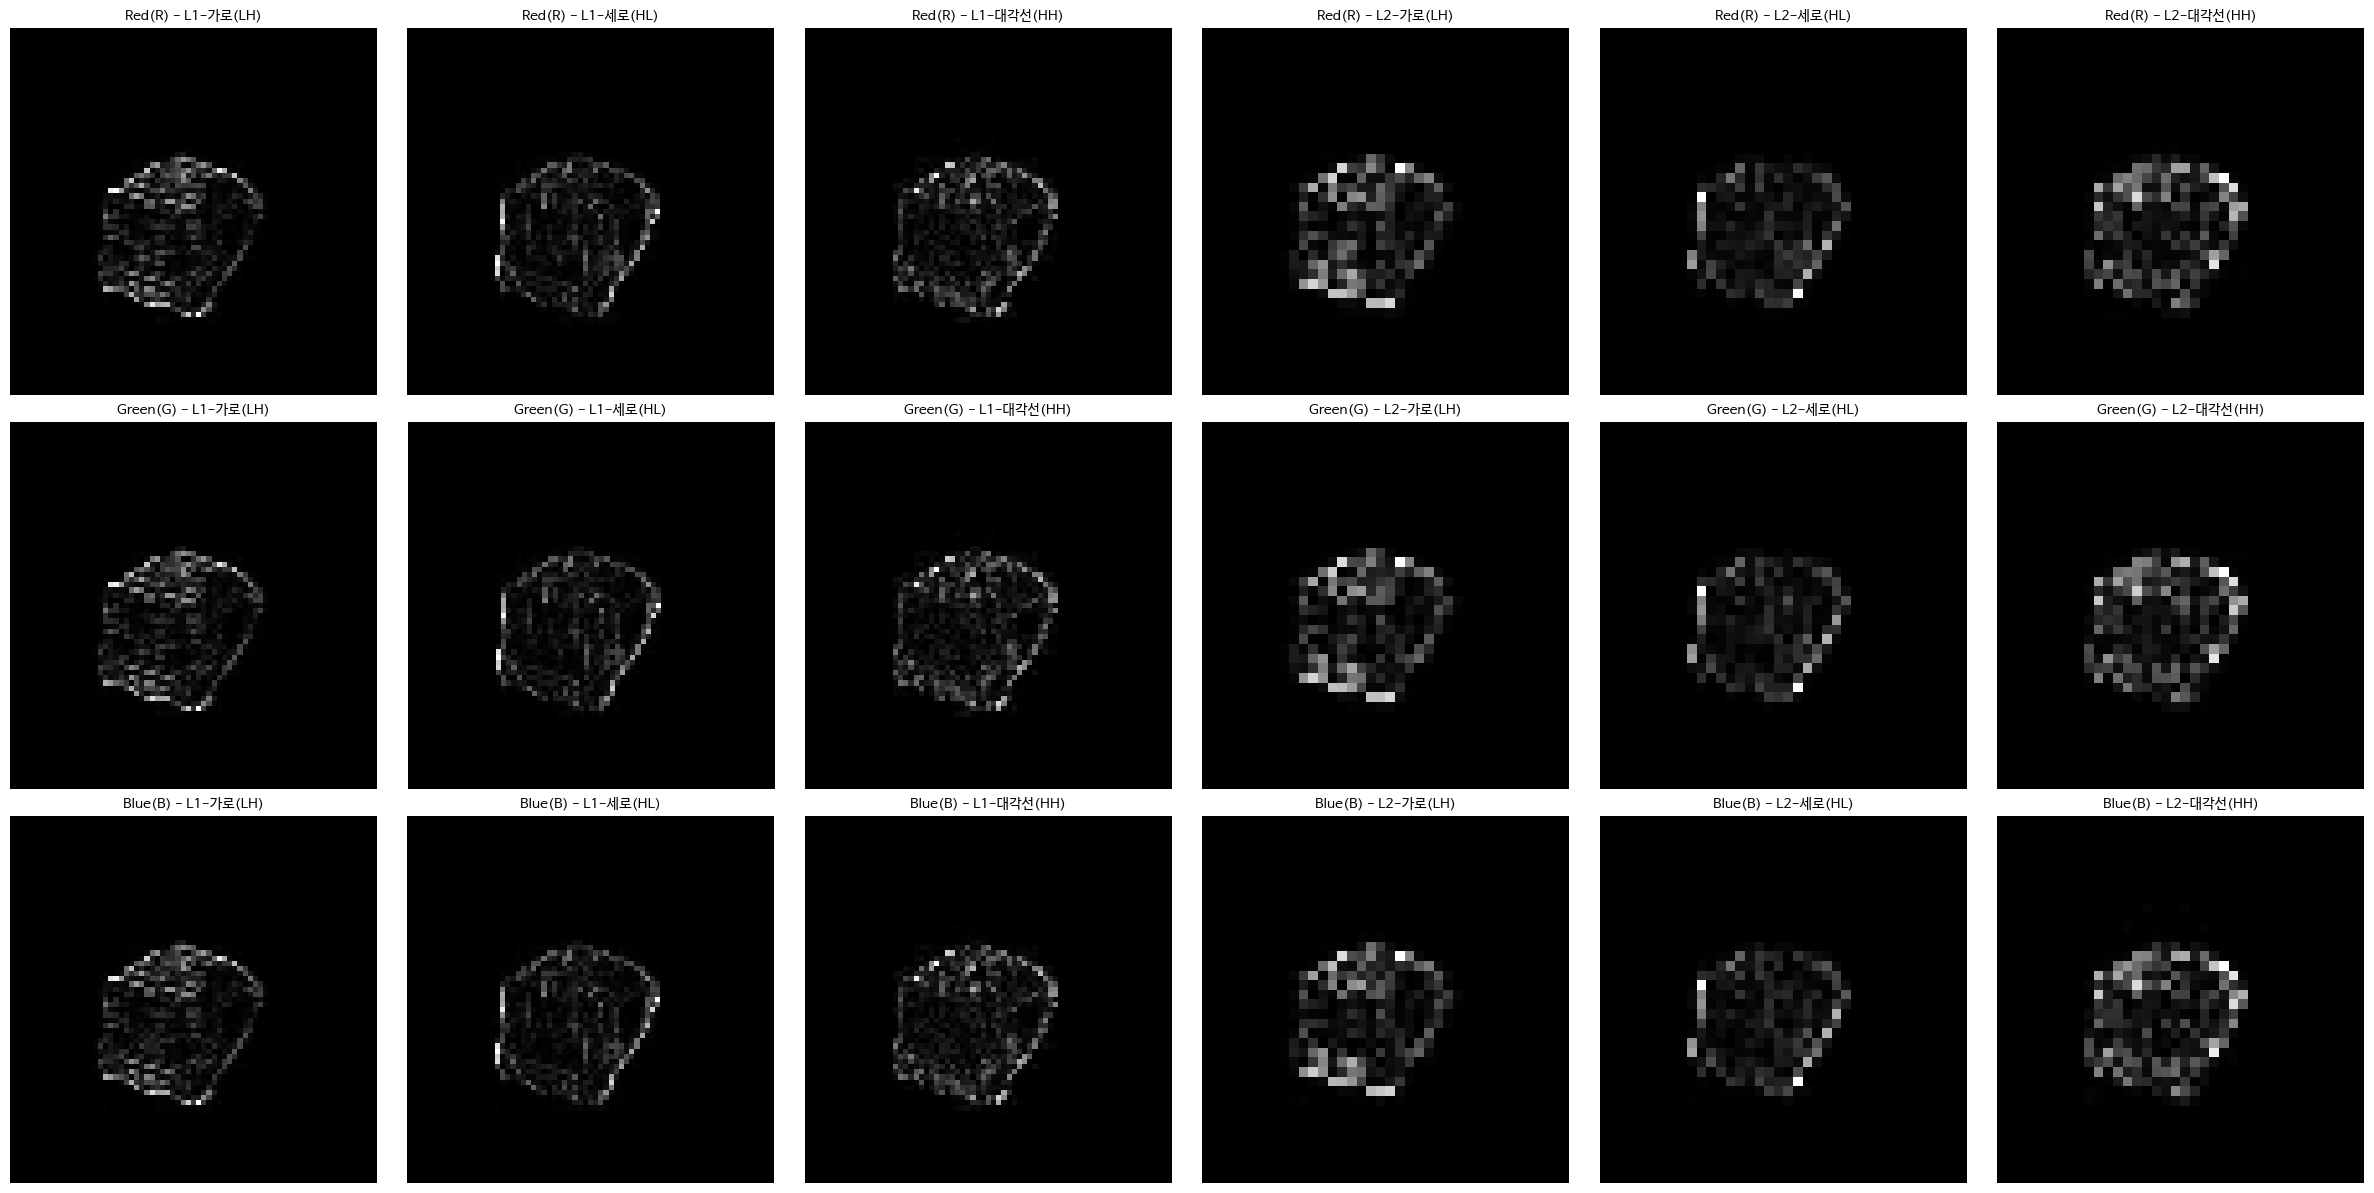

In [8]:
plot_dwt_18_features(image_path)